# Rad229_Motion_Artifacts_Demo
This function is designed to demonstrate the effects of pulsatile motion and/or bulk motion
on MR image acquisition.

The simulation assumes a single-shot top-down k-space acquistion during the complete phantom motion.

QUESTIONS

1. Adjust the "vessel" amplitude, frequency, and/or phase to create:
    - Streaking artifact
    <!-- obj['f_vsl'] = 5.0 # Vessel frequency [cycles / phase] -->

    - A bright vessel with little streaking
     <!-- obj['f_vsl'] = 0.5 # Vessel frequency [cycles / phase] -->

    - A dark vessel with little streaking

2. How would you change the "vessel" function and encoding to get perfect FOV/2 artifacts?

3. Adjust the objects bulk motion amplitude, frequency, and/or phase to create:
    - Motion artifacts

DBE@STANFORD.EDU (April 2021) for Rad229

DBE@STANFORD.EDU (April 2025) Python version for Rad229

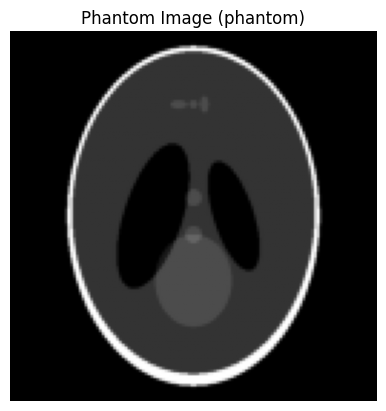

In [1]:
# -- We use the functions in mrsigpy, as well as standard numpy and matpltlib
#! git clone https://github.com/mribri999/MRSignalsSeqs.git &> /dev/null # Clones the RAD229 repo
#import sys, os
#python_code_path = '/content/MRSignalsSeqs/Python/'
#sys.path.append(python_code_path) # To load the mrsigpy functions
#os.chdir(python_code_path) # Change directory to Python folder

import numpy as np
from Rad229_MRI_Phantom import rad229_mri_phantom
import matplotlib.pyplot as plt
from scipy.ndimage import shift

# Generate a phantom object
acq = {}
acq['Nx'] = 128  # Matrix is NxN (then padded later to accommodate motion)
acq['Ny'] = 129  # Matrix is NxN (then padded later to accommodate motion)
acq['dt'] = 100e-3  # Time step [s]
acq['N_phs'] = 128  # Number of image phases [#]
acq['dur'] = acq['dt'] * (acq['N_phs'] - 1)  # Duration of motion [s]
acq['t'] = np.arange(0, acq['dur'] + acq['dt'], acq['dt'])  # Time vector [s]
acq['t_norm'] = np.arange(acq['N_phs']) / acq['N_phs']  # Normalized time vector

# Generate a phantom object
phantom, mask = rad229_mri_phantom(acq)  # Make a Shepp-Logan phantom

# Make  figure of the phantom
plt.figure
plt.imshow(phantom, cmap='gray', origin='lower');
plt.title('Phantom Image (phantom)');
plt.axis('off');

Pick one of the phantom elements (e.g the sixth one) and make it brighten and darken according to:

$$A_{vsl} \left(1 + sin\left( 2\pi f_{vsl} t \right) \right)$$

Also define a motion path for the phantom according to:

$$d_x = d_{x,max} sin\left( 2\pi f_{dx} t \right)$$

$$d_y = d_{y,max} sin\left( 2\pi f_{dy} t \right)$$

We also define some complex Gaussian noise variables here and add the noise a few cells later.



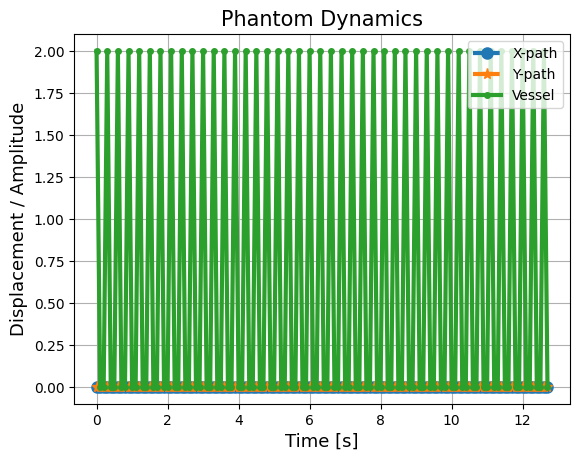

In [2]:
# Define a pulsatile "vessel" signal frequency and amplitude to simulate in-flow effect
obj = {}
obj['A_vsl'] = 2.0, # Vessel amplitude (simulates in-flow effect) [A.U.]
obj['f_vsl'] = 3.0 # Vessel frequency [cycles / phase]
obj['phi_vsl'] = (0)*np.pi # Vessel phase [radians]
obj['num'] = 4 # Identify the phantom sub-object (default phantom has 11 objects)

# Define the object's bulk motion
obj['dx_max'] = 0.0  # Max x-displacement [pixels]
obj['f_dx'] = 0.0  # Bulk frequency [cycles/phase]

obj['dy_max'] = 0.0  # Max y-displacement [pixels]
obj['f_dy'] = 0.0 # Bulk frequency [cycles/phase]

# Create the pulse amplitude function for a "vessel"
# obj['pulse_amp'] = obj['A_vsl'] * (1 + np.sin(2 * np.pi * obj['f_vsl'] * acq['t_norm'] + obj['phi_vsl']))

# Create a pulse amplitude function that is on/off
obj['pulse_amp'] = obj['A_vsl'] * (np.arange(len(acq['t_norm'])) % 3 == 0).astype(float)

# Define bulk motion path for each phase [X-displacement is OFF]
obj['xt'] = obj['dx_max'] * np.sin(2 * np.pi * obj['f_dx'] * acq['t_norm'])
obj['yt'] = obj['dy_max'] * np.sin(2 * np.pi * obj['f_dy'] * acq['t_norm'])

# Define some noise statistics
mean = 0  # Mean of the noise
std_dev = 0.025  # Standard deviation of the noise

# Plot motion and pulse amplitude
plt.figure()
plt.plot(acq['t'], obj['xt'], 'o-.', linewidth=3, markersize=8, label='X-path')
plt.plot(acq['t'], obj['yt'], '*-.', linewidth=3, markersize=8, label='Y-path')
plt.plot(acq['t'], obj['pulse_amp'], '.-', linewidth=3, markersize=8, label='Vessel')

plt.title('Phantom Dynamics', fontsize=15)
plt.xlabel('Time [s]', fontsize=13)
plt.ylabel('Displacement / Amplitude', fontsize=13)
plt.legend(loc='upper right')  # Equivalent to 'NorthWest' in MATLAB
plt.grid(True)
plt.show()

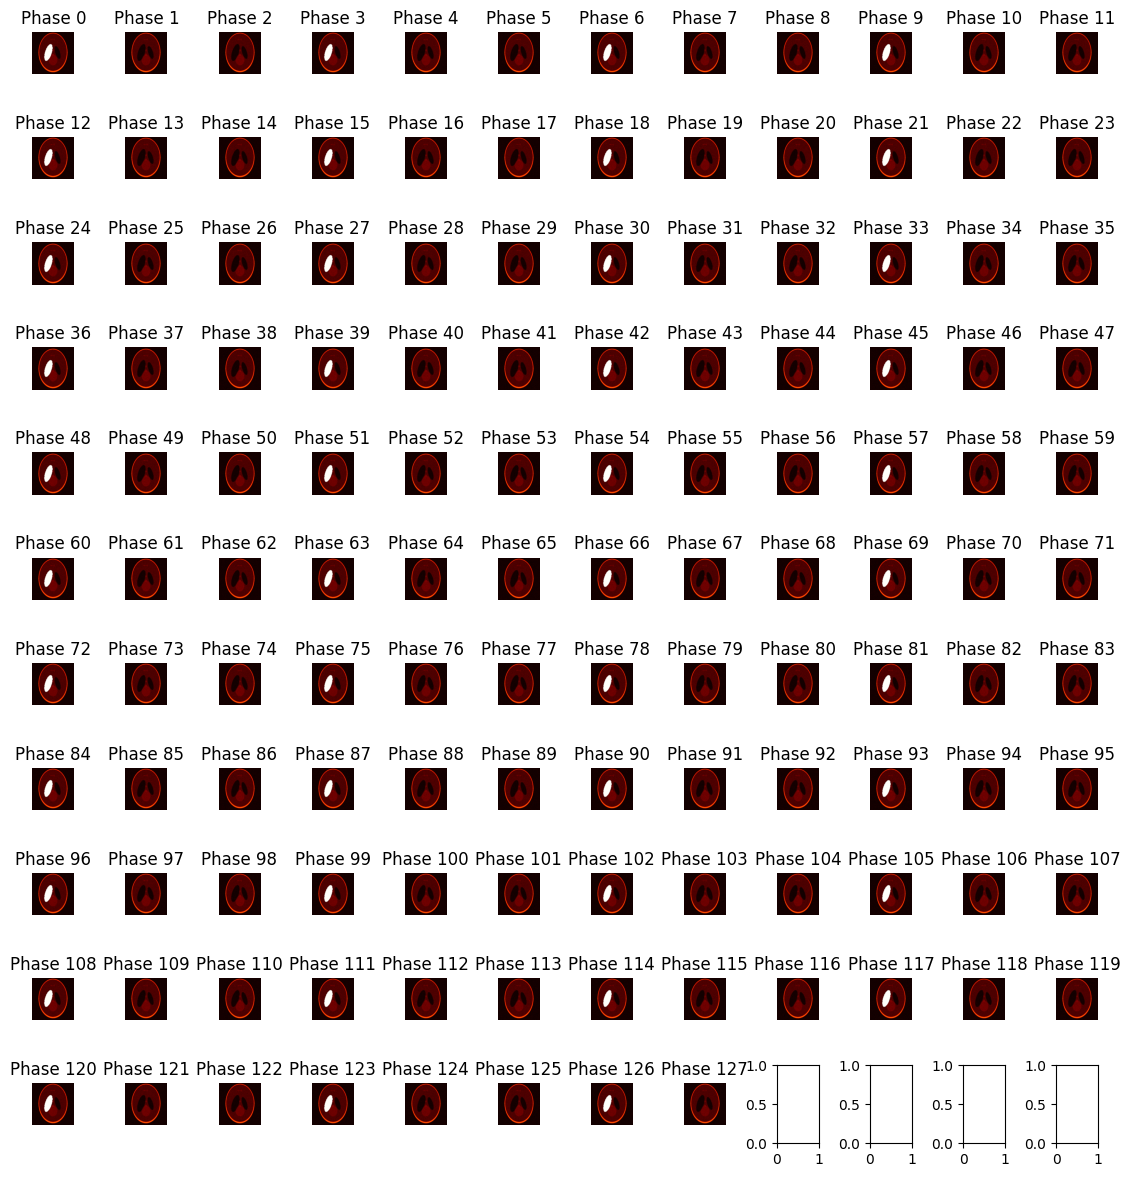

In [3]:
# Replicate the "vessel" object in time, modulate the amplitude, add it to the phantom
vsl = np.repeat(np.flipud(mask[:, :, obj['num']])[:, :, np.newaxis], acq['N_phs'], axis=2)  # Not sure why flipud is needed
vsl_dynam = vsl * obj['pulse_amp'][np.newaxis, np.newaxis, :]
phantom_dynam = np.repeat(phantom[:, :, np.newaxis], acq['N_phs'], axis=2)
phantom_dynam = phantom_dynam + vsl_dynam

# Apply both x and y displacements for all objects in phantom
for t in range(acq['N_phs']):
    dx = obj['xt'][t]  # X displacement at time t
    dy = obj['yt'][t]  # Y displacement at time t
    # Apply motion displacement to each object
    phantom_dynam[:, :, t] = shift(phantom_dynam[:, :, t], shift=(dy, dx), order=1, mode='constant', cval=0)

# Add some noise...
noise_real = np.random.normal(mean, std_dev, phantom_dynam.shape)
noise_imag = np.random.normal(mean, std_dev, phantom_dynam.shape)
complex_noise = noise_real + 1j * noise_imag

# Add it to the phantom
phantom_dynam_noise = phantom_dynam + complex_noise

# Plot each phase in its respective subplot
#fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5, 5))
n_rows = int(np.sqrt(acq['N_phs']))
n_cols = n_rows + 1
fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(n_rows, n_cols))
axes = axes.flatten()  # Flatten axes for easy iteration
for i in range(acq['N_phs']):
    ax = axes[i]
    ax.imshow(np.abs( phantom_dynam_noise[:, :, i] ), cmap='hot', origin='lower', vmin=np.min(obj['pulse_amp']), vmax=np.max(obj['pulse_amp']))
    ax.set_title(f'Phase {i}')
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

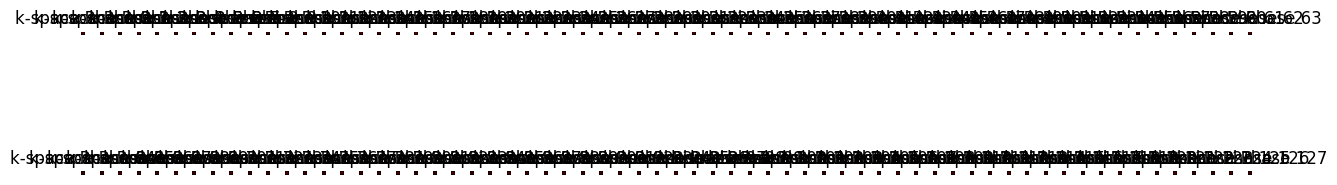

In [4]:
# Assuming PHT is a 3D NumPy array: shape (Nx, Nx, N_phs)
kspc = np.zeros_like(phantom_dynam_noise, dtype=complex)  # Preallocate k-space array

# Perform 2D FFT with fftshift for each phase
for n in range(acq['N_phs']):
    kspc[:, :, n] = np.fft.fftshift(np.fft.fft2(phantom_dynam_noise[:, :, n]))

# Visualize the magnitude of k-space
kmin = 0
kmax = np.max(np.abs(kspc)) / 10

plt.figure(figsize=(12, 4))
for i in range(acq['N_phs']):
    plt.subplot(2, int(np.ceil(acq['N_phs'] / 2)), i + 1)
    plt.imshow(np.abs(kspc[:, :, i]), cmap='hot', origin='lower', vmin=kmin, vmax=kmax)
    plt.title(f'k-space Phase {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Consider that we now have a time-series of images (vessel dynamics, motion, and noise) in the OBJECT domain.
# This is what is happening to our object while the k-space data is being acquired. 
# If we are forming a single image during these dynamic events, then blocks of k-space lines will accord with different OBJECT states.
# The k-space blocks size is sometimes called "views per segment" (VPS, i.e. k-space lines per block)

VPS = acq['Nx'] // acq['N_phs']  # Views-per-segment (assumes acq['Nx'] divisible by N_phs)
kspc_motion = np.zeros((acq['Nx'], acq['Nx']), dtype=complex)

for m in range(acq['N_phs']):
    ind0 = m * VPS
    ind1 = (m + 1) * VPS
    kspc_motion[ind0:ind1, :] = kspc[ind0:ind1, :, m]

# Reconstruct the image from motion-segmented k-space
PHT_motion = np.fft.ifft2(np.fft.ifftshift(kspc_motion))

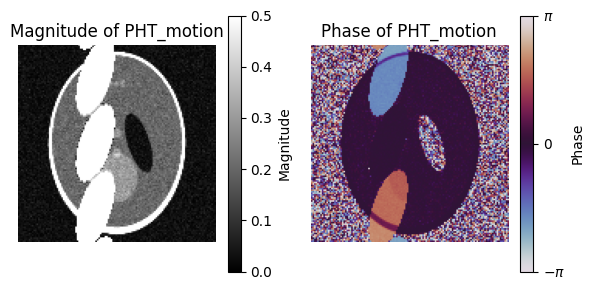

In [6]:
# Compute magnitude and phase
#magnitude = np.abs(PHT_motion)
#phase = np.angle(PHT_motion)

# Create a figure with gridspec for better control
fig = plt.figure(figsize=(6, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])  # Two columns with equal width

# Magnitude subplot
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(np.abs(PHT_motion), cmap='gray', origin='lower', vmin=0, vmax=0.5)
ax1.set_title('Magnitude of PHT_motion')
ax1.axis('off')

# Phase subplot
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(np.angle(PHT_motion), cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
ax2.set_title('Phase of PHT_motion')
ax2.axis('off')

# Add colorbars with the same height for both subplots
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical')
cbar1.ax.set_ylabel('Magnitude')

cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', ticks=[-np.pi, 0, np.pi])
cbar2.ax.set_yticklabels(['$-\\pi$', '0', '$\\pi$'])  # LaTeX-style tick labels
cbar2.ax.set_ylabel('Phase')

# Adjust layout to make sure everything fits and has the same height
plt.tight_layout()
plt.show()
